In [30]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person
from PIL import Image
import matplotlib.image as mpimg

In [31]:
KEY = "5e2e52544bab467481c90687fa201ea4"
ENDPOINT = "https://apireconfacial.cognitiveservices.azure.com/"

In [32]:
# Crear una FaceClient autenticada.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [35]:
# Detect a face in an image that contains a single face
single_face_image_url = 'saul.jpg'
image=mpimg.imread(single_face_image_url)
single_image_name = os.path.basename(single_face_image_url)

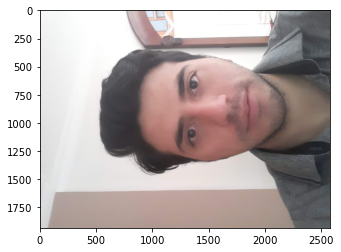

In [36]:
plt.imshow(image)

None


In [ ]:
# We use detection model 2 because we are not retrieving attributes.
detected_faces = face_client.face.detect_with_stream(image=image, detectionModel='detection_01')
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Display the detected face ID in the first single-face image.
# Face IDs are used for comparison to faces (their IDs) detected in other images.
print('Detected face ID from', single_image_name, ':')
for face in detected_faces: print (face.face_id)
print()

# Save this ID for use in Find Similar
first_image_face_ID = detected_faces[0].face_id

In [15]:
# Detect a face in an image that contains a single face
single_face_image_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'
single_image_name = os.path.basename(single_face_image_url)
# We use detection model 2 because we are not retrieving attributes.
detected_faces = face_client.face.detect_with_url(url=single_face_image_url, detectionModel='detection_02')
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))


# Download the image from the url
response = requests.get(single_face_image_url)
img = Image.open(BytesIO(response.content))

# For each face returned use the face rectangle and draw a red box.
print('Drawing rectangle around face... see popup for results.')
draw = ImageDraw.Draw(img)
for face in detected_faces:
    draw.rectangle(getRectangle(face), outline='red')

# Display the image in the users default image browser.
img.show()

Drawing rectangle around face... see popup for results.


In [16]:
# Detect the faces in an image that contains multiple faces
# Each detected face gets assigned a new ID
multi_face_image_url = "http://www.historyplace.com/kennedy/president-family-portrait-closeup.jpg"
multi_image_name = os.path.basename(multi_face_image_url)
# We use detection model 2 because we are not retrieving attributes.
detected_faces2 = face_client.face.detect_with_url(url=multi_face_image_url, detectionModel='detection_02')

In [17]:
# Search through faces detected in group image for the single face from first image.
# First, create a list of the face IDs found in the second image.
second_image_face_IDs = list(map(lambda x: x.face_id, detected_faces2))
# Next, find similar face IDs like the one detected in the first image.
similar_faces = face_client.face.find_similar(face_id=first_image_face_ID, face_ids=second_image_face_IDs)
if not similar_faces[0]:
    print('No similar faces found in', multi_image_name, '.')

In [18]:
# Used in the Person Group Operations and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

# Used for the Delete Person Group example.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

In [19]:
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

# Define woman friend
woman = face_client.person_group_person.create(PERSON_GROUP_ID, "Woman")
# Define man friend
man = face_client.person_group_person.create(PERSON_GROUP_ID, "Man")
# Define child friend
child = face_client.person_group_person.create(PERSON_GROUP_ID, "Child")

In [20]:
'''
Detect faces and register to correct person
'''
# Find all jpeg images of friends in working directory
woman_images = [file for file in glob.glob('*.jpg') if file.startswith("w")]
man_images = [file for file in glob.glob('*.jpg') if file.startswith("m")]
child_images = [file for file in glob.glob('*.jpg') if file.startswith("ch")]

# Add to a woman person
for image in woman_images:
    w = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, woman.person_id, w)

# Add to a man person
for image in man_images:
    m = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, man.person_id, m)

# Add to a child person
for image in child_images:
    ch = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, child.person_id, ch)

In [21]:
'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
test_image_array = 'images/test-image-person-group.jpg'
image = open(test_image_array, 'r+b')

print('Pausing for 60 seconds to avoid triggering rate limit on free account...')
time.sleep (60)

# Detect faces
face_ids = []
# We use detection model 2 because we are not retrieving attributes.
faces = face_client.face.detect_with_stream(image, detectionModel='detection_02')
for face in faces:
    face_ids.append(face.face_id)

Pausing for 60 seconds to avoid triggering rate limit on free account...


In [22]:
# Identify faces
results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
print('Identifying faces in {}'.format(os.path.basename(image.name)))
if not results:
    print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
for person in results:
    if len(person.candidates) > 0:
        print('Person for face ID {} is identified in {} with a confidence of {}.'.format(person.face_id, os.path.basename(image.name), person.candidates[0].confidence)) # Get topmost confidence score
    else:
        print('No person identified for face ID {} in {}.'.format(person.face_id, os.path.basename(image.name)))

APIErrorException: (PersonGroupNotTrained) Person group not trained.